# 📌 1️⃣ Install Dependencies

In [1]:
!pip install tensorflow numpy pandas opencv-python matplotlib tqdm scikit-learn albumentations

# 📌 2️⃣ Import Necessary Libraries

In [2]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import logging
tf.get_logger().setLevel(logging.ERROR)  
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
import shutil
import random

2025-05-20 09:02:37.167584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747731757.415576      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747731757.486411      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 📌 3️⃣ Load and Inspect Dataset

In [3]:
dataset_path = "/kaggle/input/Data Files"

#DEFINE CLASS LABELS
class_labels = ["NORMAL" ,"NONANNOTATEDAMD", "NONANNOTATEDDME"]

#DATASET STRUCTURE
for folder in class_labels:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} images")

NORMAL: 218 images
NONANNOTATEDAMD: 77 images
NONANNOTATEDDME: 745 images


# 🔍 Sample Original Images (3 per class)

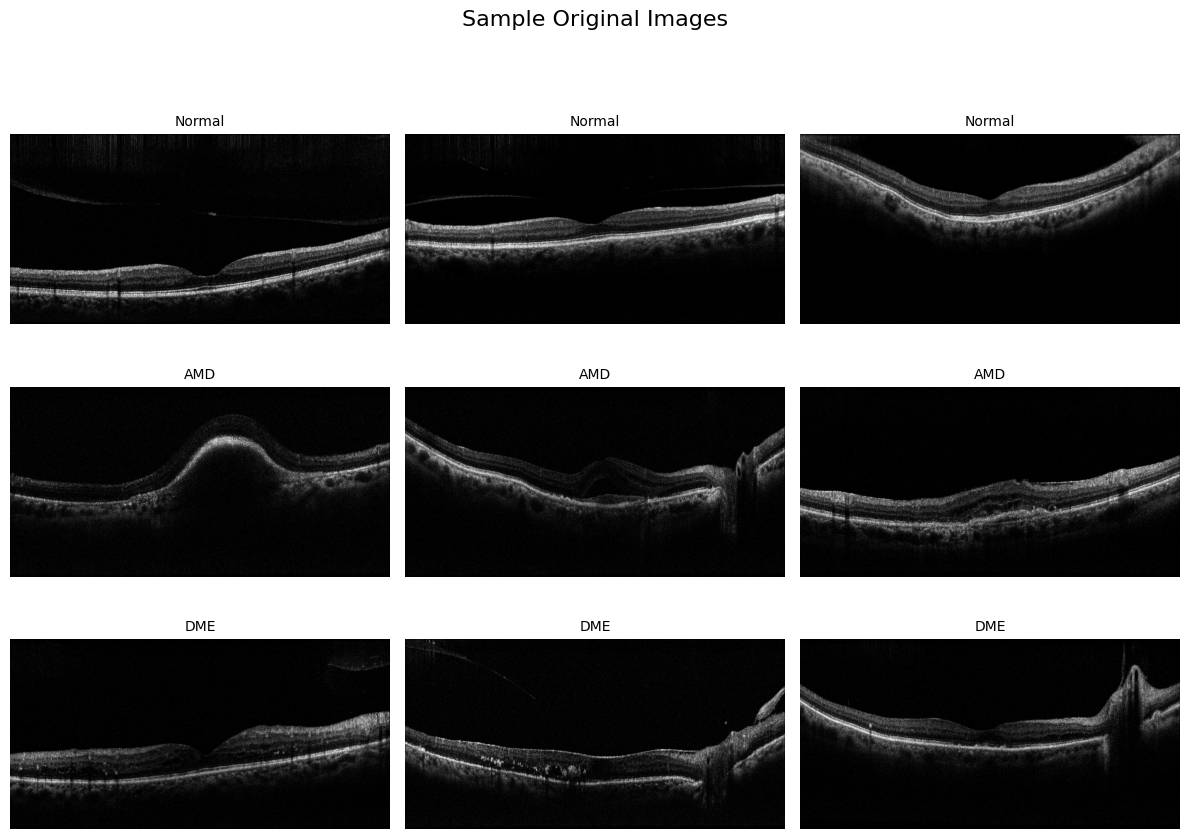

In [4]:
class_labels = ["NORMAL", "NONANNOTATEDAMD", "NONANNOTATEDDME"]
display_labels = {"NORMAL": "Normal", "NONANNOTATEDAMD": "AMD", "NONANNOTATEDDME": "DME"}
dataset_path = "/kaggle/input/Data Files" 

fig, axes = plt.subplots(len(class_labels), 3, figsize=(12, 9))

for row, folder in enumerate(class_labels):
    folder_path = os.path.join(dataset_path, folder)
    images = os.listdir(folder_path)
    selected = random.sample(images, 3) if len(images) >= 3 else images

    for col, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        axes[row, col].set_title(display_labels[folder], fontsize=10)

plt.suptitle("Sample Original Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

# 📌 4️⃣ Preprocess Dataset

In [5]:
TARGET_SIZE = (224, 224)  
preprocessed_path = "/kaggle/working/Preprocessed_Data"
os.makedirs(preprocessed_path, exist_ok=True)

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}")
        return None
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    resized_img = cv2.resize(img, TARGET_SIZE)
    return resized_img

for folder in class_labels:
    folder_path = os.path.join(dataset_path, folder)
    save_folder = os.path.join(preprocessed_path, folder)
    os.makedirs(save_folder, exist_ok=True)

    for img_name in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
        img_path = os.path.join(folder_path, img_name)
        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            save_path = os.path.join(save_folder, img_name)
            cv2.imwrite(save_path, processed_img)

print("Preprocessing complete.")

Processing NONANNOTATEDDME: 100%|██████████| 745/745 [00:10<00:00, 67.97it/s]

Preprocessing complete.


# 🔍 Sample Preprocessed Images (3 Per Class)

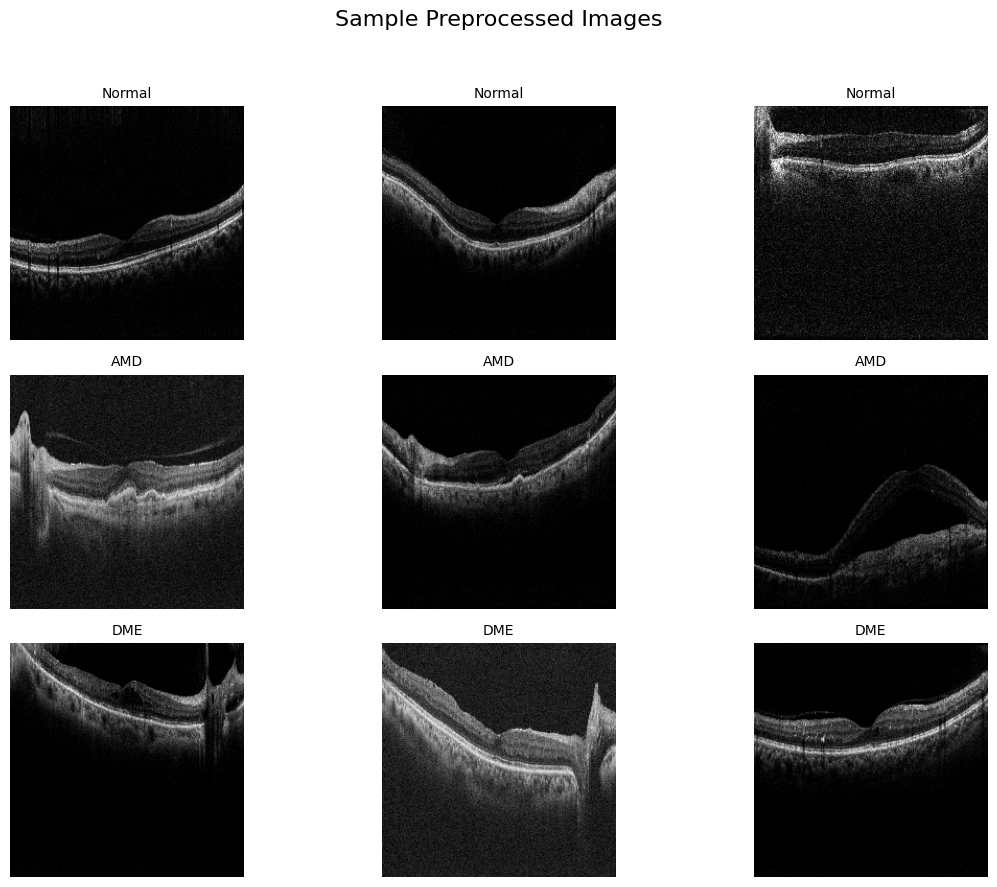

In [6]:
class_labels = ["NORMAL", "NONANNOTATEDAMD", "NONANNOTATEDDME"]
display_labels = {"NORMAL": "Normal", "NONANNOTATEDAMD": "AMD", "NONANNOTATEDDME": "DME"}

fig, axes = plt.subplots(len(class_labels), 3, figsize=(12, 9))

for row, folder in enumerate(class_labels):
    folder_path = os.path.join(preprocessed_path, folder)
    images = os.listdir(folder_path)
    selected = random.sample(images, 3) if len(images) >= 3 else images

    for col, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        axes[row, col].set_title(display_labels[folder], fontsize=10)

plt.suptitle("Sample Preprocessed Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 📌 **5️⃣ Augmentation To Reach (1500 Per Class)** 

In [7]:
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.Blur(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5)
])

augmented_classes = {
    "NONANNOTATEDAMD": 1500 - 77,
    "NONANNOTATEDDME": 1500 - 745,
    "NORMAL": 1500 - 218
}

for category, num_augments in augmented_classes.items():
    folder_path = os.path.join(preprocessed_path, category)
    original_images = os.listdir(folder_path)

    print(f"Augmenting {num_augments} images for {category}")

    for i in tqdm(range(num_augments)):
        img_name = random.choice(original_images)
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        augmented_img = augmentation(image=img)["image"]
        save_path = os.path.join(folder_path, f"aug_{i}_{img_name}")
        cv2.imwrite(save_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

print("Augmentation complete. All classes now have 1500 images.")

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Augmenting 1423 images for NONANNOTATEDAMD


100%|██████████| 1423/1423 [00:02<00:00, 632.43it/s]


Augmenting 755 images for NONANNOTATEDDME


100%|██████████| 755/755 [00:01<00:00, 621.46it/s]


Augmenting 1282 images for NORMAL


100%|██████████| 1282/1282 [00:02<00:00, 630.82it/s]

Augmentation complete. All classes now have 1500 images.


# 🔍 Inspect and Ensure Final Count

In [8]:
for folder in class_labels:
    folder_path = os.path.join(preprocessed_path, folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} images")

NORMAL: 1500 images
NONANNOTATEDAMD: 1500 images
NONANNOTATEDDME: 1500 images


# 🔍 View Sample Augmented Images

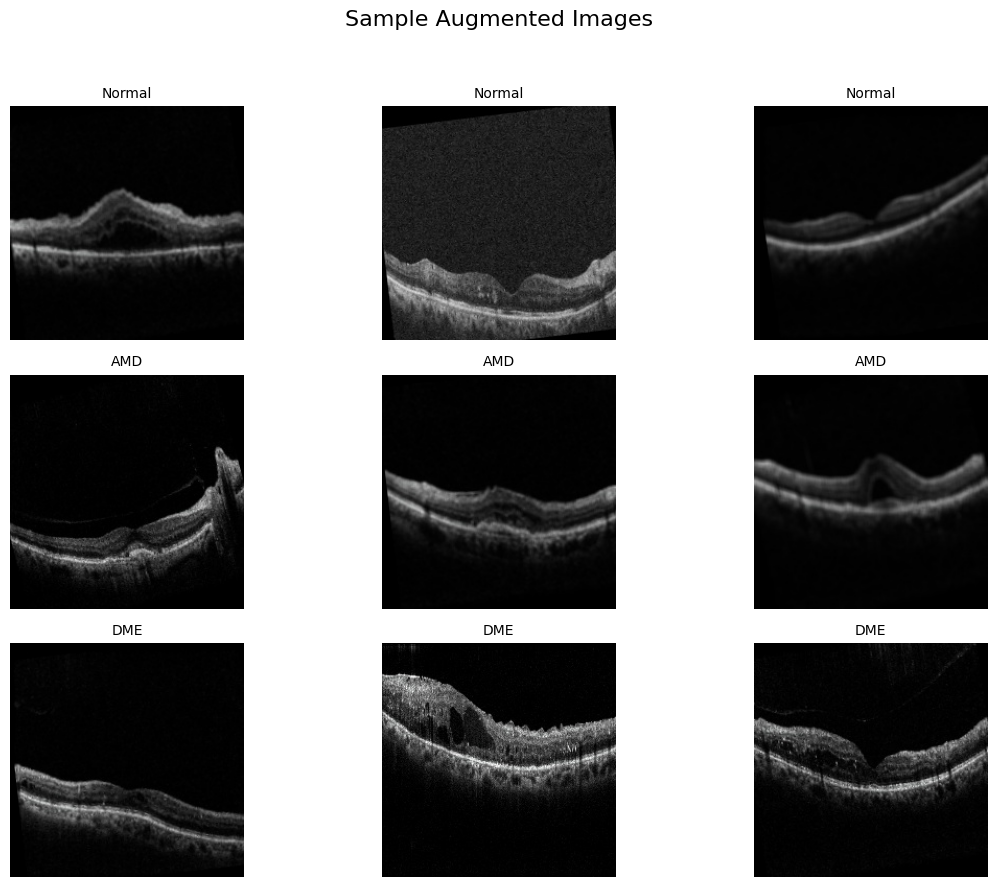

In [9]:
class_labels = ["NORMAL", "NONANNOTATEDAMD", "NONANNOTATEDDME"]
display_labels = {"NORMAL": "Normal", "NONANNOTATEDAMD": "AMD", "NONANNOTATEDDME": "DME"}

fig, axes = plt.subplots(len(class_labels), 3, figsize=(12, 9))

for row, folder in enumerate(class_labels):
    folder_path = os.path.join(preprocessed_path, folder)
    images = [img for img in os.listdir(folder_path) if img.startswith("aug_")]
    selected = random.sample(images, 3) if len(images) >= 3 else images

    for col, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        axes[row, col].set_title(display_labels[folder], fontsize=10)

plt.suptitle("Sample Augmented Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 📌 6️⃣ Segmentation (Generate Threshold-Based Simulated Masks)

In [10]:
segmentation_masks_path = "/kaggle/working/Segmentation_Masks"
os.makedirs(segmentation_masks_path, exist_ok=True)

for folder in class_labels:
    mask_folder = os.path.join(segmentation_masks_path, folder)
    os.makedirs(mask_folder, exist_ok=True)

    image_folder = os.path.join(preprocessed_path, folder)
    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        #SIMULATED SEGMENTATION USING SIMPLE INTENSITY THRESHOLD
        _, mask = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)

        mask_path = os.path.join(mask_folder, img_name)
        cv2.imwrite(mask_path, mask)

print("Segmentation masks created using intensity thresholding.")

Segmentation masks created using intensity thresholding.


# 🔍 Sample Segmentation Masks (3 per class)

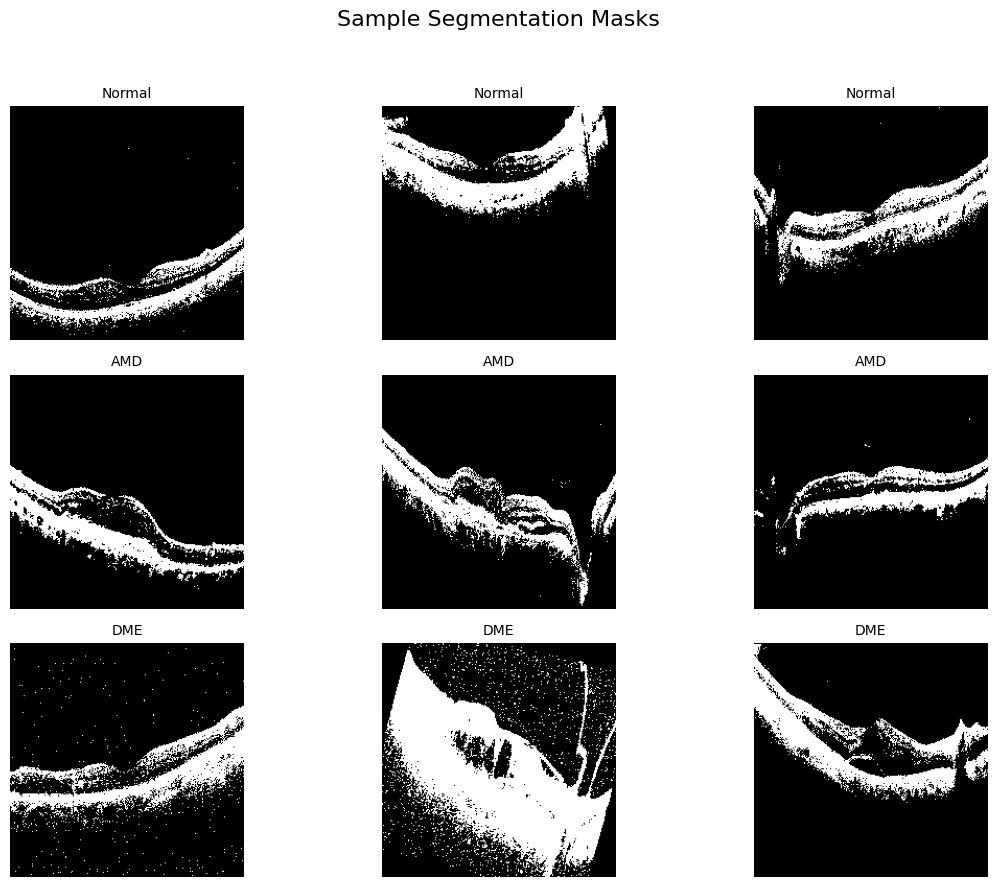

In [11]:
class_labels = ["NORMAL", "NONANNOTATEDAMD", "NONANNOTATEDDME"]
display_labels = {"NORMAL": "Normal", "NONANNOTATEDAMD": "AMD", "NONANNOTATEDDME": "DME"}

fig, axes = plt.subplots(len(class_labels), 3, figsize=(12, 9))

for row, folder in enumerate(class_labels):
    folder_path = os.path.join(segmentation_masks_path, folder)
    images = os.listdir(folder_path)
    selected = random.sample(images, 3) if len(images) >= 3 else images

    for col, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        axes[row, col].imshow(mask, cmap="gray")
        axes[row, col].axis("off")
        axes[row, col].set_title(display_labels[folder], fontsize=10)

plt.suptitle("Sample Segmentation Masks", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 📌 7️⃣ Train, Validation, and Test Split

In [12]:
train_ratio, val_ratio, test_ratio = 0.60, 0.20, 0.20

#DEFINE TRAIN, VALIDATION, TEST DIRECTORIES
train_path = os.path.join(preprocessed_path, "train")
val_path = os.path.join(preprocessed_path, "val")
test_path = os.path.join(preprocessed_path, "test")

#CREATE DIRECTORIES
for path in [train_path, val_path, test_path]:
    os.makedirs(path, exist_ok=True)

def split_dataset(folder):
    file_list = os.listdir(os.path.join(segmentation_masks_path, folder))
    np.random.shuffle(file_list)
    
    train_idx = int(len(file_list) * train_ratio)
    val_idx = int(len(file_list) * (train_ratio + val_ratio))
    
    return file_list[:train_idx], file_list[train_idx:val_idx], file_list[val_idx:]


for folder in class_labels:
    os.makedirs(os.path.join(train_path, folder), exist_ok=True)
    os.makedirs(os.path.join(val_path, folder), exist_ok=True)
    os.makedirs(os.path.join(test_path, folder), exist_ok=True)

    train_files, val_files, test_files = split_dataset(folder)

    for file in train_files:
        shutil.move(os.path.join(preprocessed_path, folder, file), os.path.join(train_path, folder, file))
    for file in val_files:
        shutil.move(os.path.join(preprocessed_path, folder, file), os.path.join(val_path, folder, file))
    for file in test_files:
        shutil.move(os.path.join(preprocessed_path, folder, file), os.path.join(test_path, folder, file))

print("Data split and moved to train/val/test folders successfully.")

Data split and moved to train/val/test folders successfully.


# 📌 8️⃣ Define Data Generators

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2700 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


# 📌 9️⃣ Models Training

In [14]:
from tensorflow.keras.applications import ResNet152, InceptionV3,MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

#MODELS
models_to_train = {
    "ResNet152": ResNet152,
    "InceptionV3": InceptionV3,
    "MobileNetV2": MobileNetV2,
}
trained_models = {}
histories = {}
model_paths = {}

for name, base_model_fn in models_to_train.items():
    print(f"\nTraining model: {name}")
  
    base_model = base_model_fn(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output) 
    x = Dense(256, activation="relu")(x) 
    x = Dropout(0.5)(x)  
    output = Dense(len(class_labels), activation="softmax")(x)  

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

    path = f"/kaggle/working/best_{name.lower()}_model.keras"
    model_paths[name] = path

    
    checkpoint = ModelCheckpoint(
        path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
    )

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        batch_size=32,
        callbacks=[checkpoint]
    )

    trained_models[name] = model
    histories[name] = history


Training model: ResNet152


I0000 00:00:1747731807.977149      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747731960.360321      90 service.cc:148] XLA service 0x795e14008210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747731960.361316      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747731973.227826      90 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747732010.238529      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.6276 - loss: 0.8302
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /kaggle/working/best_resnet152_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.6293 - loss: 0.8266 - val_accuracy: 0.3333 - val_loss: 1.1817
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9378 - loss: 0.1754
Epoch 2: val_accuracy did not improve from 0.33333
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 412ms/step - accuracy: 0.9377 - loss: 0.1753 - val_accuracy: 0.3333 - val_loss: 1.1574
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9735 - loss: 0.0740
Epoch 3: val_accuracy improved from 0.33333 to 0.33444, saving model to /kaggle/working/best_resnet152_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 467ms/step - accuracy: 0.9735 - loss: 0.0741 - val_accuracy: 0.3344 - val_loss: 1.1466
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9779 - loss: 0.0747
Epoch 4: val_accuracy did not improve

E0000 00:00:1747733284.613351      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747733284.810562      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


27/85 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.4597 - loss: 1.2077

E0000 00:00:1747733304.567395      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747733304.763301      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5834 - loss: 0.9491
Epoch 1: val_accuracy improved from -inf to 0.39444, saving model to /kaggle/working/best_mobilenetv2_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 89s 380ms/step - accuracy: 0.5850 - loss: 0.9459 - val_accuracy: 0.3944 - val_loss: 1.9889
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9168 - loss: 0.2224
Epoch 2: val_accuracy improved from 0.39444 to 0.41778, saving model to /kaggle/working/best_mobilenetv2_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9169 - loss: 0.2221 - val_accuracy: 0.4178 - val_loss: 2.2338
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9613 - loss: 0.1148
Epoch 3: val_accuracy improved from 0.41778 to 0.42444, saving model to /kaggle/working/best_mobilenetv2_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9613 - loss: 0.1147 - val_accuracy: 0.4244 - val_loss: 2.5588
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accu

# 🔍 Training and Validation Curves

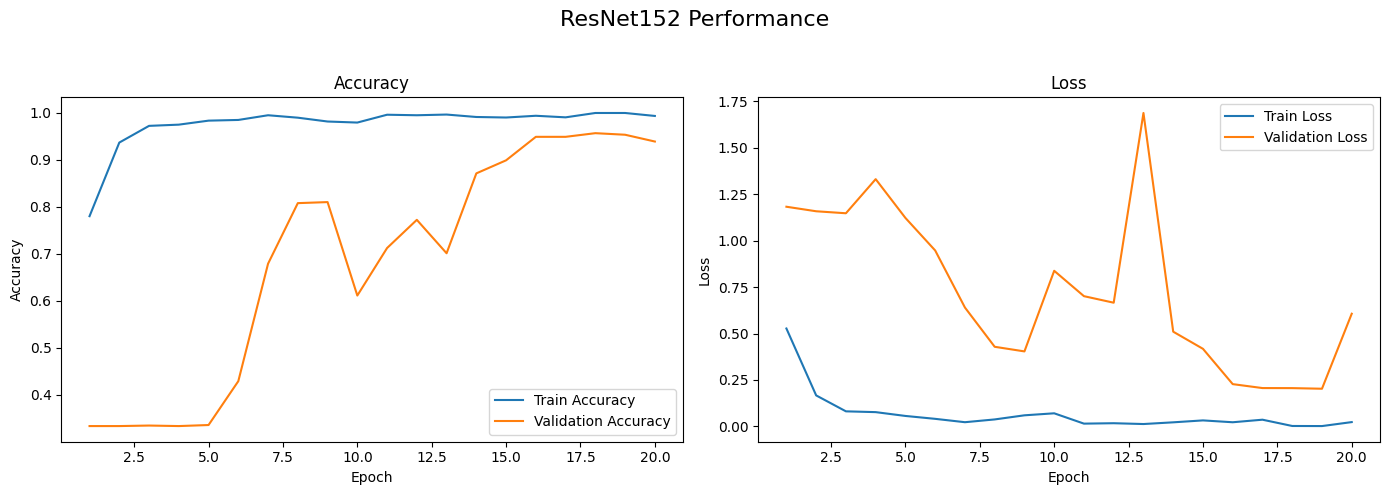

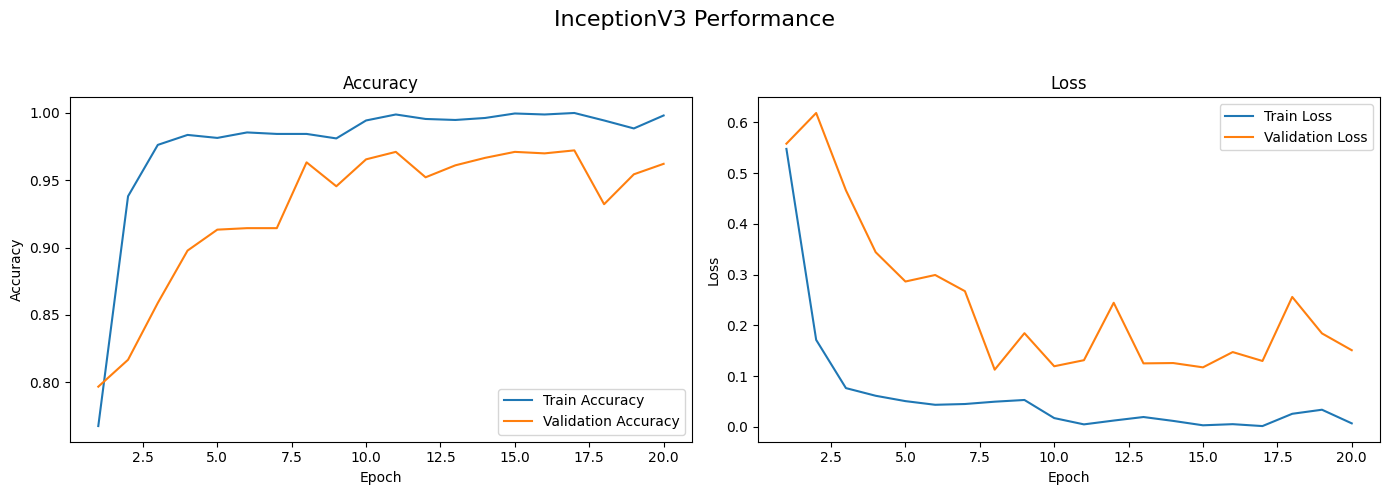

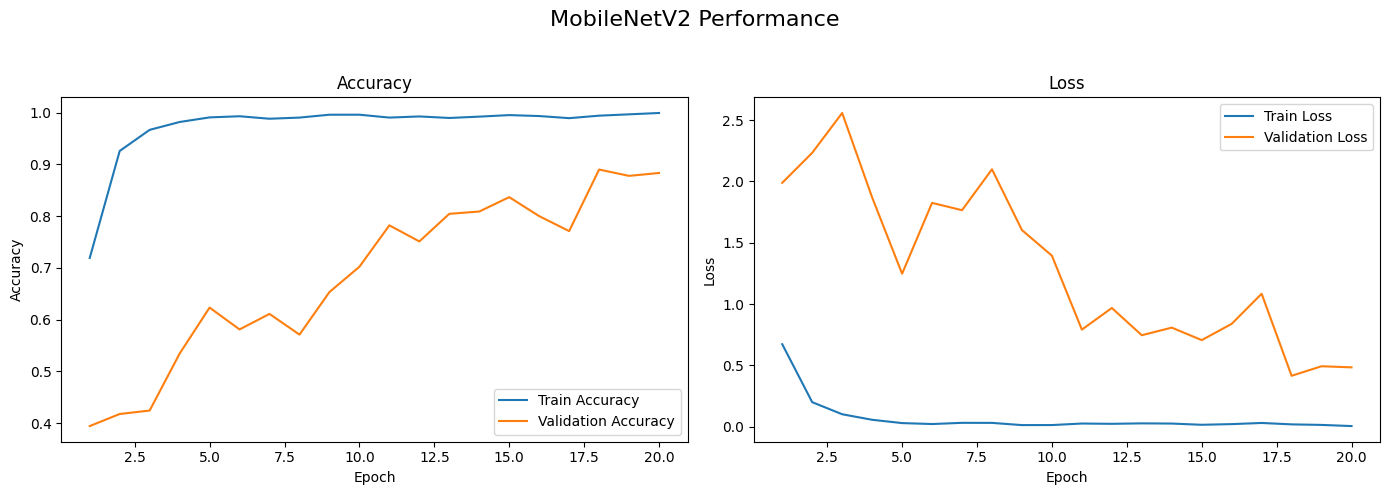

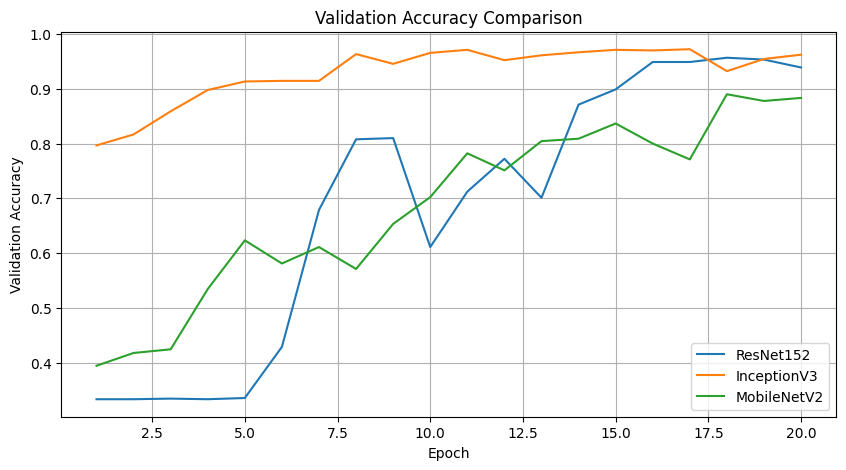

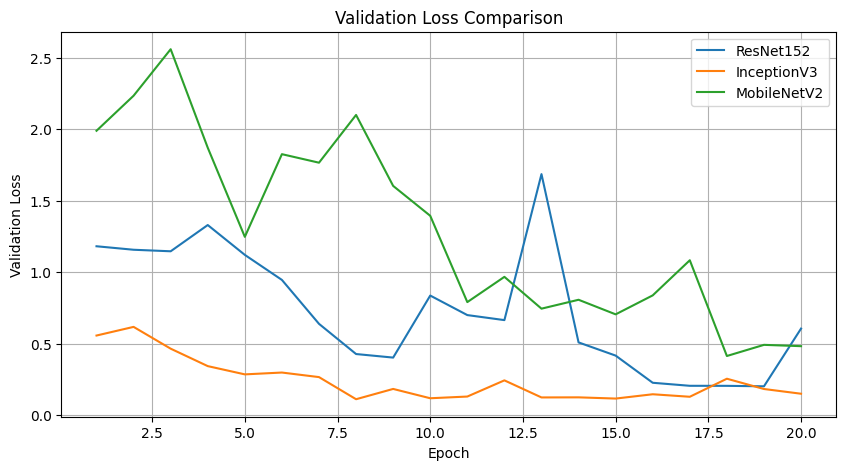

In [15]:
import matplotlib.pyplot as plt
for name, history in histories.items():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.suptitle(f"{name} Performance", fontsize=16)

    #ACCURACY
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    #LOSS
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


#VALIDATION ACCURACY COMPARISON
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    val_acc = history.history['val_accuracy']
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#VALIDATION LOSS COMPARISON
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    val_loss = history.history['val_loss']
    plt.plot(range(1, len(val_loss) + 1), val_loss, label=name)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 📌 🔟 Performance Evaluation


Evaluating ResNet152


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 466ms/step

Classification Report for ResNet152:

              precision    recall  f1-score   support

         AMD       1.00      0.99      0.99       300
         DME       0.95      0.91      0.93       300
      Normal       0.91      0.96      0.93       300

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



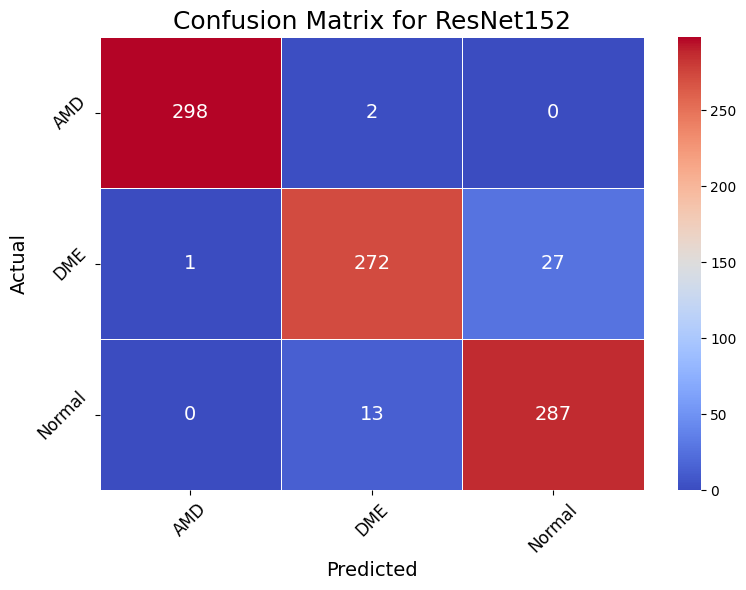


Evaluating InceptionV3
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step

Classification Report for InceptionV3:

              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       300
         DME       0.94      0.96      0.95       300
      Normal       0.96      0.94      0.95       300

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



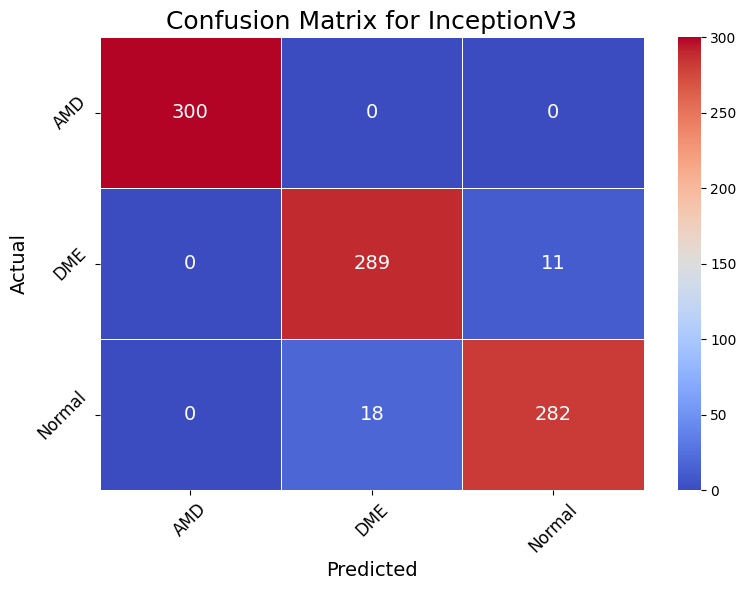


Evaluating MobileNetV2
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step

Classification Report for MobileNetV2:

              precision    recall  f1-score   support

         AMD       1.00      0.85      0.92       300
         DME       0.88      0.88      0.88       300
      Normal       0.81      0.92      0.86       300

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



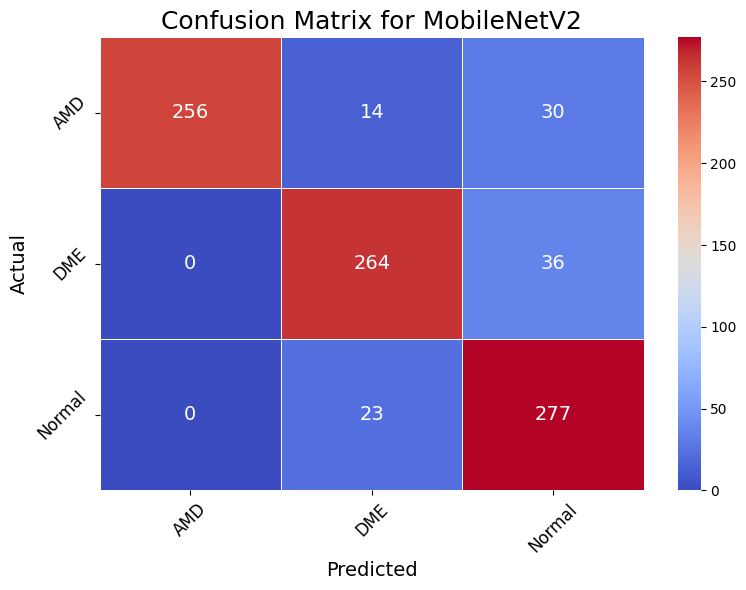

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

label_map = {
    "NONANNOTATEDAMD": "AMD",
    "NONANNOTATEDDME": "DME",
    "NORMAL": "Normal"
}

original_class_names = list(test_generator.class_indices.keys())
clean_class_names = [label_map[name] for name in original_class_names]

reports = {}

for name in trained_models:
    print(f"\nEvaluating {name}")
    
    model = tf.keras.models.load_model(model_paths[name])
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    #CLASSIFICATION REPORT
    report = classification_report(
        y_true,
        y_pred,
        target_names=clean_class_names,
        output_dict=True
    )
    reports[name] = report

    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_true, y_pred, target_names=clean_class_names))

    #CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=True, linewidths=0.5,
                annot_kws={"size": 14},
                xticklabels=clean_class_names,
                yticklabels=clean_class_names)

    plt.title(f"Confusion Matrix for {name}", fontsize=18)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

# 🔍 Comparing Models Performance

In [17]:
summary_df = pd.DataFrame()
for name, report in reports.items():
    acc = report['accuracy']
    macro_avg = report['macro avg']

    summary_df[name] = {
        "Accuracy": acc,
        "Precision (macro avg)": macro_avg["precision"],
        "Recall (macro avg)": macro_avg["recall"],
        "F1-score (macro avg)": macro_avg["f1-score"]
    }

summary_df = summary_df.T
summary_df_sorted = summary_df.sort_values(by="Accuracy", ascending=False)
summary_df_sorted

,Accuracy,Precision (macro avg),Recall (macro avg),F1-score (macro avg)
InceptionV3,0.967778,0.967942,0.967778,0.967773
ResNet152,0.952222,0.952801,0.952222,0.952197
MobileNetV2,0.885556,0.894886,0.885556,0.886995
